In [ ]:
#install
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=2f7e837459d7f701b90c72631bbcfe37d0b8202ed0f1eaf49d93ee844392797a
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python_speech_features


In [ ]:
import _pickle as cPickle
import numpy as np
import pandas as pd
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import time
import os
import numpy as np
from sklearn import preprocessing
import seaborn as sn
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import python_speech_features 
from collections import Counter
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Mgr/EASAR

/content/drive/.shortcut-targets-by-id/1cCSqf0S8VsSbj8YH3OUMmtEEr6QfM5kf/EASAR


In [ ]:
def calculate_delta(mfcc, number):
    """Calculate differential coefficients"""

    rows,cols = mfcc.shape
    deltas = np.zeros((rows,number))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first = 0
            else:
                first = i-j
            if i+j > rows -1:
                second = rows -1
            else:
                second = i+j
            index.append((second,first))
            j+=1
        deltas[i] = ( mfcc[index[0][0]]-mfcc[index[0][1]] + (2 * (mfcc[index[1][0]]-mfcc[index[1][1]])) ) / 10
    return deltas

def extract_features(signal,rate):
     
    #signal, rate, length of widow in ms, step between successive windows in seconds, the number of cepstrum to return, 
    #appendEnergy – if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.
    mfcc_numb = 5
    mfcc_feature = python_speech_features.mfcc(signal,rate, 0.025, 0.01,mfcc_numb,appendEnergy = True)
    
    mfcc_feature = preprocessing.scale(mfcc_feature) #standarize data
    delta = calculate_delta(mfcc_feature, mfcc_numb)
    combined = np.hstack((mfcc_feature,delta)) 
    return combined

In [ ]:
#paths to data
source   = "baza_arg/"
#path where training speakers will be saved
dest = "speaker_models_arg_svm/"
train_file = "baza_arg_enroll.txt" # 
n_files = 5

In [ ]:
count = 1
file_paths = open(train_file,'r')

label_dict = {}
y_train = []
x_train = np.asarray(())
features = np.asarray(())
avg_data = 0
training_data = 0
# Extracting features for each speaker (5 files per speakers)
for i, path in enumerate(file_paths):    
    path = path.strip()   
    # read the audio    
    Fs, audio = read(source + path)
    # extract 40 dimensional MFCC & delta MFCC features

    vector = extract_features(audio, Fs)
    training_data += len(audio)
    print( path)

    if features.size == 0:
        features = vector
    else:
        features = np.vstack((features, vector))
    # when features of 5 files of speaker are concatenated, then do model 
    if count == n_files:    
        if x_train.size == 0:
            x_train = features
        else:
            x_train = np.vstack((x_train, features))
        for j in range(len(features)):
            y_train.append((i+1)//n_files)
        
        mn = features.shape
        print ('+ modeling completed for speaker:',path.split("-")[0],".svm"," with data point = ",mn)
        features = np.asarray(())
        label_dict[(i+1)//n_files] = path.split("-")[0]
        
        training_data = 0
        count = 0
    count = count + 1
file_paths.close()


speaker1-/n0010101.wav
speaker1-/n0010102.wav
speaker1-/n0010103.wav
speaker1-/n0010104.wav
speaker1-/n0010105.wav
+ modeling completed for speaker: speaker1 .svm  with data point =  (563, 10)
speaker2-/n0020101.wav
speaker2-/n0020102.wav
speaker2-/n0020103.wav
speaker2-/n0020104.wav
speaker2-/n0020105.wav
+ modeling completed for speaker: speaker2 .svm  with data point =  (824, 10)
speaker3-/n0030101.wav
speaker3-/n0030102.wav
speaker3-/n0030103.wav
speaker3-/n0030104.wav
speaker3-/n0030105.wav
+ modeling completed for speaker: speaker3 .svm  with data point =  (1500, 10)
speaker4-/n0040101.wav
speaker4-/n0040102.wav
speaker4-/n0040103.wav
speaker4-/n0040104.wav
speaker4-/n0040105.wav
+ modeling completed for speaker: speaker4 .svm  with data point =  (703, 10)
speaker6-/n0060101.wav
speaker6-/n0060102.wav
speaker6-/n0060103.wav
speaker6-/n0060104.wav
speaker6-/n0060105.wav
+ modeling completed for speaker: speaker6 .svm  with data point =  (540, 10)
speaker7-/n0070101.wav
speaker7-/n

In [ ]:
#training model
model = SVC(C=5, class_weight = "balanced", decision_function_shape = 'ovo')
model.fit(x_train, y_train)

SVC(C=5, class_weight='balanced', decision_function_shape='ovo')

In [ ]:
picklefile = "model_5.svm"
cPickle.dump(model, open(dest + picklefile,'wb'))

test

In [ ]:
test_file = "baza_arg_test.txt"  #  
file_paths = open(test_file, 'r')

svm_model = cPickle.load(open(dest + "model_5.svm",'rb'))

files  = [os.path.join(source, f[0:len(f)-1]) for f in file_paths]

In [ ]:
accuracy = 0
y_tested = []
y_pred = []
total_sample = 0
for i, path in enumerate(files):
    total_sample += 1
    #read file
    Fs, audio = read(path)
    path = path.strip()
    print (path)
    #extract mfcc feautures 
    vector = extract_features(audio, Fs)
    #predict the cluster
    temp = svm_model.predict(vector)
    #take most probable
    y_test = Counter(temp).most_common()[0]
    #check if it was proper prediction
    if(path.split("/")[1].split("-")[0] == label_dict[y_test[0]]):
        accuracy += 1
        print ("\tPredicted as - ", label_dict[y_test[0]])
        print('-'*20)
    else:
        print ("\tPredicted as - ",  label_dict[y_test[0]])
        print('-'*20)
    y_tested.append(path.split("/")[1].split("-")[0])
    y_pred.append(label_dict[y_test[0]])
print("Accuracy =", accuracy/total_sample*100, "%")
print(y_tested)
print(y_pred)

baza_arg/speaker1-/n0010106.wav
	Predicted as -  speaker1
--------------------
baza_arg/speaker1-/n0010107.wav
	Predicted as -  speaker1
--------------------
baza_arg/speaker1-/n0010108.wav
	Predicted as -  speaker1
--------------------
baza_arg/speaker1-/n0010109.wav
	Predicted as -  speaker1
--------------------
baza_arg/speaker1-/n0010110.wav
	Predicted as -  speaker1
--------------------
baza_arg/speaker2-/n0020106.wav
	Predicted as -  speaker2
--------------------
baza_arg/speaker2-/n0020107.wav
	Predicted as -  speaker2
--------------------
baza_arg/speaker2-/n0020108.wav
	Predicted as -  speaker2
--------------------
baza_arg/speaker2-/n0020109.wav
	Predicted as -  speaker2
--------------------
baza_arg/speaker2-/n0020110.wav
	Predicted as -  speaker2
--------------------
baza_arg/speaker3-/n0030106.wav
	Predicted as -  speaker3
--------------------
baza_arg/speaker3-/n0030107.wav
	Predicted as -  speaker3
--------------------
baza_arg/speaker3-/n0030108.wav
	Predicted as -  spe

In [ ]:
cm = confusion_matrix(y_tested,y_pred)
cm

array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0,

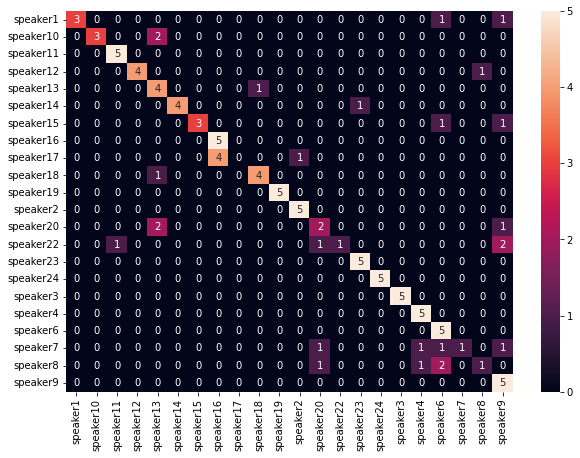

In [ ]:
df_cm = pd.DataFrame(cm, index=np.unique(y_tested), columns=np.unique(y_tested))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
def am_I_there(path):
  Fs, audio = read(path)
  vector = extract_features(audio, Fs)
  temp = svm_model.predict(vector)
  y_test = Counter(temp).most_common()[0]
  
  if(Counter(temp).most_common()[0][1] < 200):
    print('Not in database')
  else:
    if(path.split("/")[1].split("-")[0] == label_dict[y_test[0]]):
      print(i+1, ":", path.split("/")[1].split("-")[0], "Predicted as:", label_dict[y_test[0]])
    else:
      print("-----------------------------------------------")
      print(i+1, ":", path.split("/")[1].split("-")[0], "Predicted as:", label_dict[y_test[0]])
      print("-----------------------------------------------")

In [ ]:
am_I_there('baza_arg/speaker3-/n0030101.wav')

110 : speaker3 Predicted as: speaker3
